
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


Multiclass KNN

In [44]:
# Multiclass KNN

# Split features and target variable
X = ha.drop(columns=['cp'])
y = ha['cp']

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define ColumnTransformer
ct = ColumnTransformer(
    [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"), ["sex", "output"]),
      ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder = "drop"
)

# Define KNN pipeline
knn_pipeline = Pipeline([
    ("preprocessor", ct),
    ("knn", KNeighborsClassifier())]
)

param_grid = {'knn__n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

best_k = grid_search.best_params_['knn__n_neighbors']
best_score = grid_search.best_score_
print(f"Best k: {best_k}")
print(f"Best cross-validated Accuracy Score: {best_score:.4f}")

Best k: 15
Best cross-validated Accuracy Score: 0.5422


In [45]:
final_knn_pipeline = Pipeline([
    ("preprocessor", ct),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)

final_knn_pipeline.fit(X, y)
y_pred_knn = final_knn_pipeline.predict(X)

knn_cm = confusion_matrix(y, y_pred_knn)
print(knn_cm)

print(classification_report(y, y_pred_knn))

[[109   7  11   1]
 [ 14  14  16   0]
 [ 31  11  38   1]
 [ 10   2   8   0]]
              precision    recall  f1-score   support

           0       0.66      0.85      0.75       128
           1       0.41      0.32      0.36        44
           2       0.52      0.47      0.49        81
           3       0.00      0.00      0.00        20

    accuracy                           0.59       273
   macro avg       0.40      0.41      0.40       273
weighted avg       0.53      0.59      0.55       273



Decision Tree

In [78]:
# Decision Tree

# Define the pipeline
dt_pipeline = Pipeline([
    ("preprocessor", ct),
    ("dt", DecisionTreeClassifier(random_state=1))]
)

param_grid = {
    'dt__ccp_alpha': [0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated Accuracy Score: {best_score:.4f}")

Best parameters: {'dt__ccp_alpha': 0.01}
Best cross-validated Accuracy Score: 0.5345


In [76]:
# Define the final pipeline
final_dt_pipeline = Pipeline([
    ("preprocessor", ct),
    ("dt", DecisionTreeClassifier(ccp_alpha=0.01))
])

final_dt_pipeline.fit(X, y)
y_pred_dt = final_dt_pipeline.predict(X)

dt_cm = confusion_matrix(y, y_pred_dt)
print(dt_cm)

# Performance metrics
print(classification_report(y, y_pred_dt))

[[111   0  17   0]
 [ 13   0  31   0]
 [ 34   0  47   0]
 [  9   0  11   0]]
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       128
           1       0.00      0.00      0.00        44
           2       0.44      0.58      0.50        81
           3       0.00      0.00      0.00        20

    accuracy                           0.58       273
   macro avg       0.28      0.36      0.31       273
weighted avg       0.44      0.58      0.50       273



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


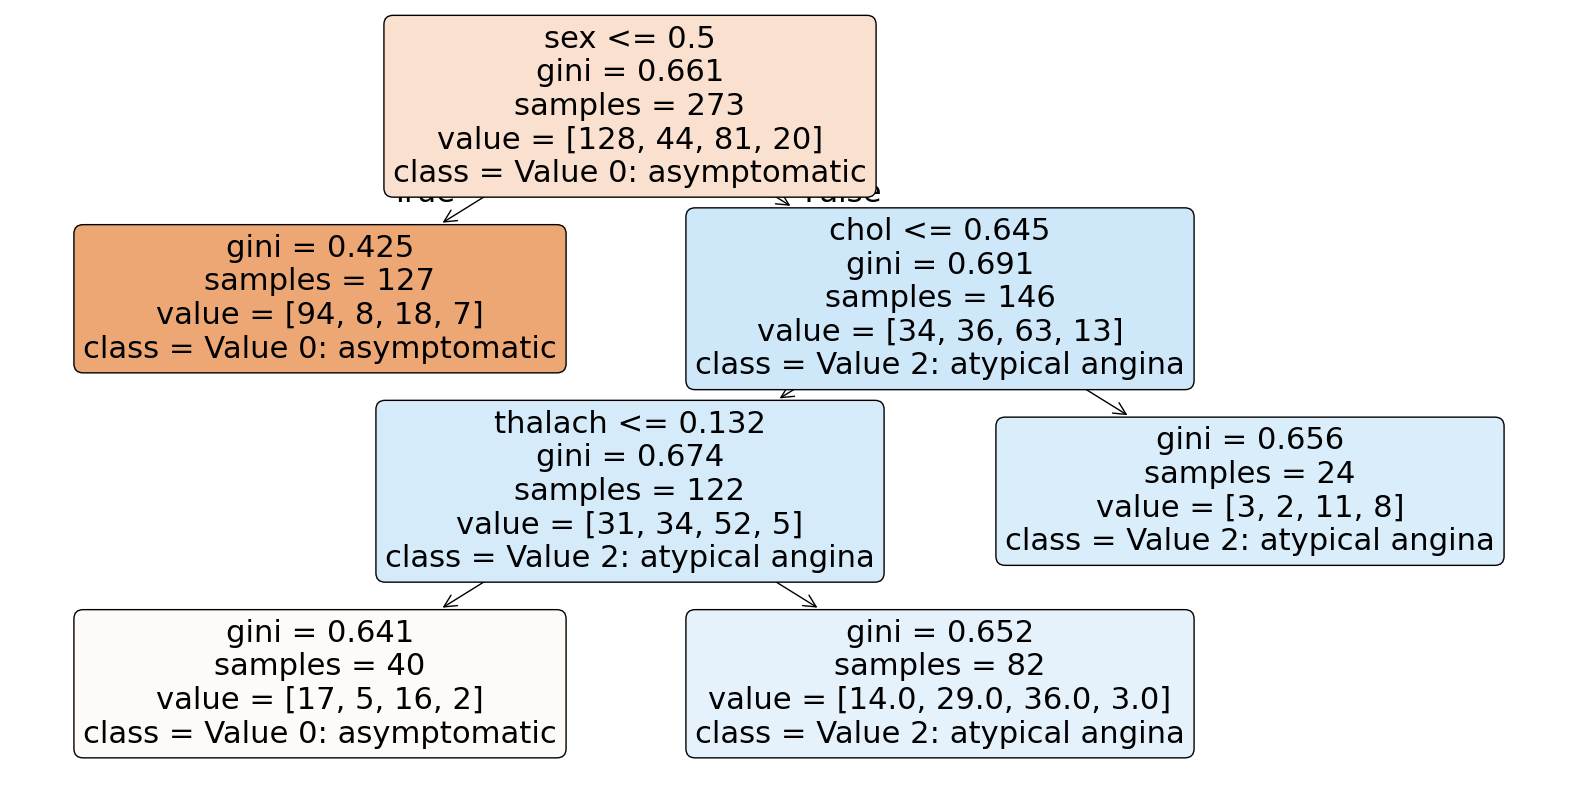

In [77]:
plt.figure(figsize=(20, 10))
plot_tree(final_dt_pipeline.named_steps['dt'], filled=True, feature_names=X.columns, class_names=["Value 0: asymptomatic", "Value 1: typical angina", "Value 2: atypical angina", "Value 3: non-anginal pain"], rounded=True)
plt.show()

Root Split (sex <= 0.5):  
- Divides samples based on sex.  
- The left node (females) is dominated by Class 0 (asymptomatic), while the right node (males) contains a mix of all classes.  

Second Split (Right Node: chol <= 0.645):  
- Further splits the male group based on cholesterol levels.  
- Samples with lower cholesterol (chol <= 0.645) remain mixed but lean towards Class 2 (atypical angina).  

In [85]:
# LDA
# Define the pipeline
lda_pipeline = Pipeline([
    ("preprocessor", ct),
    ("lda", LinearDiscriminantAnalysis())]
)

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
    'lda__n_components': [None, 1, 2, 3]  # Adjust based on the number of classes
}

# Perform GridSearchCV
grid_search = GridSearchCV(lda_pipeline, param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated Accuracy Score: {best_score:.4f}")

Best parameters: {'lda__n_components': None, 'lda__shrinkage': 0.1, 'lda__solver': 'lsqr'}
Best cross-validated Accuracy Score: 0.5676


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

In [87]:
# Define the final pipeline
final_lda_pipeline = Pipeline([
    ("preprocessor", ct),
    ("lda", LinearDiscriminantAnalysis(n_components=None, shrinkage=0.1, solver='lsqr'))
])

final_lda_pipeline.fit(X, y)
y_pred_lda = final_lda_pipeline.predict(X)

lda_cm = confusion_matrix(y, y_pred_lda)
print(lda_cm)

# Performance metrics
print(classification_report(y, y_pred_lda))

[[100   2  26   0]
 [  8   2  33   1]
 [ 24   4  52   1]
 [  9   0   9   2]]
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       128
           1       0.25      0.05      0.08        44
           2       0.43      0.64      0.52        81
           3       0.50      0.10      0.17        20

    accuracy                           0.57       273
   macro avg       0.47      0.39      0.38       273
weighted avg       0.54      0.57      0.53       273



## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [90]:
ha[f'cp_is_0'] = (ha['cp'] == 0).astype(int)
ha[f'cp_is_1'] = (ha['cp'] == 1).astype(int)
ha[f'cp_is_2'] = (ha['cp'] == 2).astype(int)
ha[f'cp_is_3'] = (ha['cp'] == 3).astype(int)

In [94]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def logistic_regression_cv(X, target_column, columns_to_drop):
    y = X[target_column]
    X = X.drop(columns=columns_to_drop, axis=1)

    ct = ColumnTransformer(
        [("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"),
          make_column_selector(dtype_include=object))],
        remainder="passthrough"
    )

    logreg_pipeline = Pipeline([
        ("preprocessing", ct),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    lr_scores = cross_val_score(logreg_pipeline, X, y, cv=stratified_cv, scoring="f1_macro")

    mean_score = lr_scores.mean()
    print(f"Mean f1_macro score for {target_column}: {mean_score:.4f}")


cp_drop = ["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0", "cp"]
cp3_target = "cp_is_3"
cp2_target = "cp_is_2"
cp1_target = "cp_is_1"
cp0_target = "cp_is_0"

logistic_regression_cv(ha, cp3_target, cp_drop)
logistic_regression_cv(ha, cp2_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)

Mean f1_macro score for cp_is_3: 0.4810
Mean f1_macro score for cp_is_2: 0.4443
Mean f1_macro score for cp_is_1: 0.4551
Mean f1_macro score for cp_is_1: 0.4551


The OvR approach was best at distinguishing cp = 3.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
ha = ha.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis =1)

In [103]:
def compare_ovo(ha, cp_a, cp_b):
    """
    Compare two classes (cp_a and cp_b) using Logistic Regression and compute ROC-AUC.
    """
    # Filter the dataset for the two classes
    ha_filtered = ha[(ha["cp"] == cp_a) | (ha["cp"] == cp_b)].copy()
    ha_filtered["is_comparison"] = (ha_filtered["cp"] == cp_b).astype(int)  # Binary target

    # Define features (X) and binary target (y)
    X = ha_filtered.drop(columns=["cp", "is_comparison"])
    y = ha_filtered["is_comparison"]

    # Preprocessing for numeric and categorical features
    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop='first'),
         X.select_dtypes(include=["object", "category"]).columns),
        ("pass", "passthrough", X.select_dtypes(exclude=["object", "category"]).columns)
    ])

    # Define the logistic regression pipeline
    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
    ])

    # Cross-validate and compute the mean ROC-AUC score
    roc_auc = cross_val_score(log_pipeline, X, y, cv=5, scoring="roc_auc").mean()
    return roc_auc

# Perform OvO comparisons
roc_auc_cp0_vs_cp1 = compare_ovo(ha, 0, 1)
roc_auc_cp0_vs_cp2 = compare_ovo(ha, 0, 2)
roc_auc_cp0_vs_cp3 = compare_ovo(ha, 0, 3)

# Print results
print(f"ROC AUC (cp=0 vs cp=1): {roc_auc_cp0_vs_cp1:.4f}")
print(f"ROC AUC (cp=0 vs cp=2): {roc_auc_cp0_vs_cp2:.4f}")
print(f"ROC AUC (cp=0 vs cp=3): {roc_auc_cp0_vs_cp3:.4f}")

ROC AUC (cp=0 vs cp=1): 1.0000
ROC AUC (cp=0 vs cp=2): 1.0000
ROC AUC (cp=0 vs cp=3): 1.0000
